In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'savefig.dpi': 1200})
tab20_colors = plt.cm.get_cmap('tab20').colors
tab20_colors = [c for i, c in enumerate(tab20_colors) if i//2 not in [4, 5, 6]]

import os, random, time, pickle, torch
import numpy as np

from jarvis.utils import time_str

if not os.path.exists('figs'):
    os.makedirs('figs')

In [2]:
from jarvis.vision import prepare_datasets
from torch.utils.data import DataLoader

dataset = prepare_datasets('CIFAR10', 'vision_datasets')
loader = DataLoader(dataset)
images, labels = [], []
for image, label in loader:
    images.append(image)
    labels.append(label)
images_low = torch.cat(images)
labels_low = torch.cat(labels)

preparing mixed image for alpha 0.05...


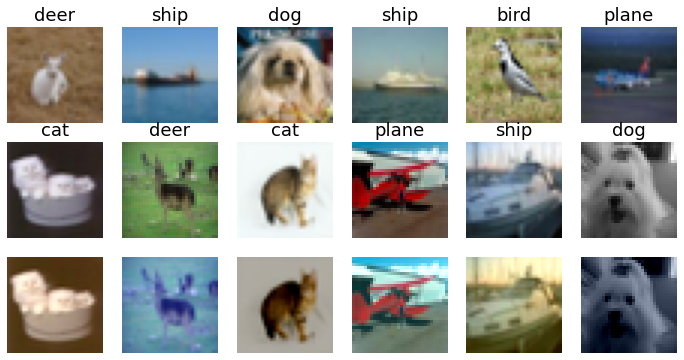

preparing mixed image for alpha 0.1...


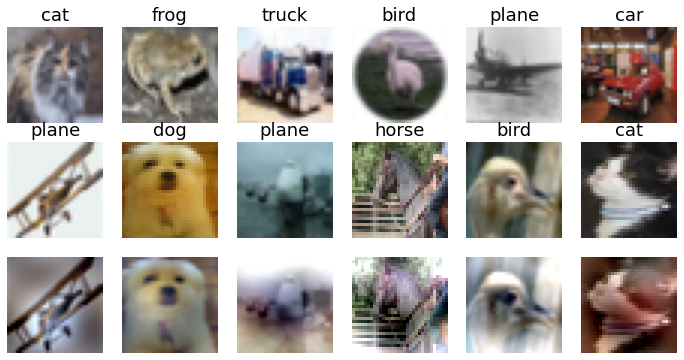

preparing mixed image for alpha 0.15...


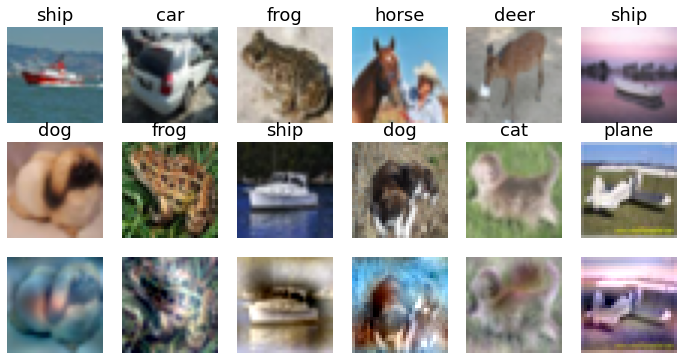

preparing mixed image for alpha 0.2...


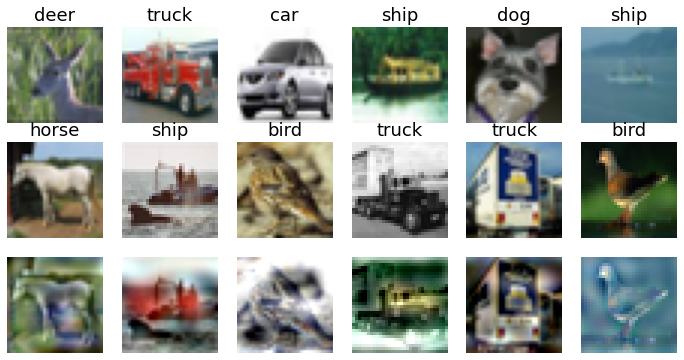

preparing mixed image for alpha 0.25...


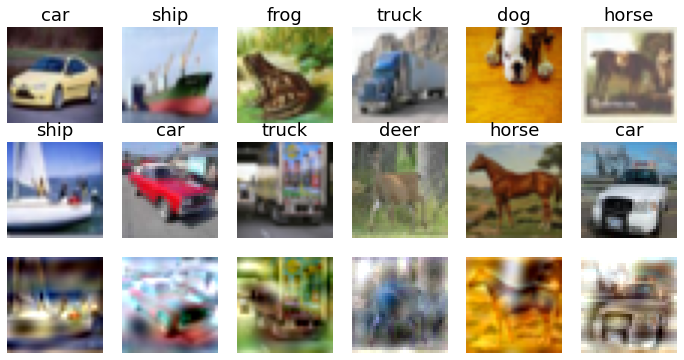

preparing mixed image for alpha 0.3...


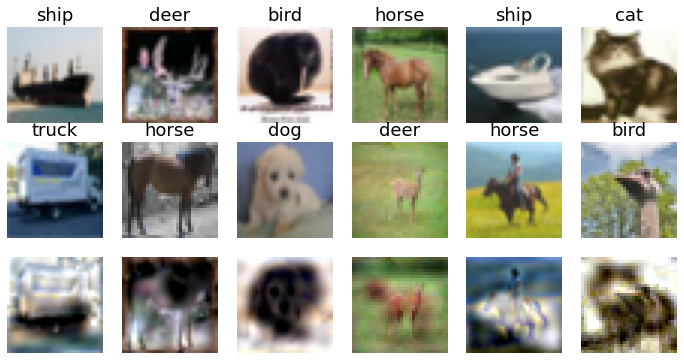

preparing mixed image for alpha 0.35...


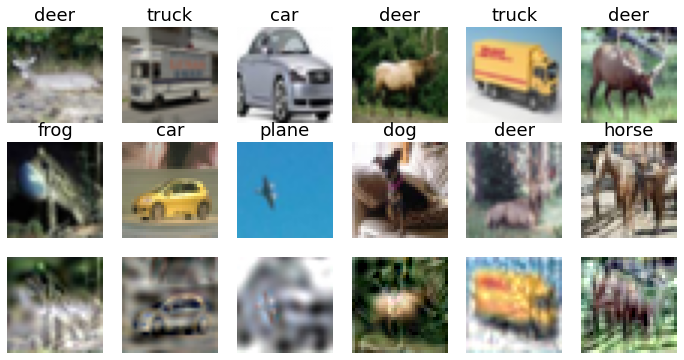

preparing mixed image for alpha 0.4...


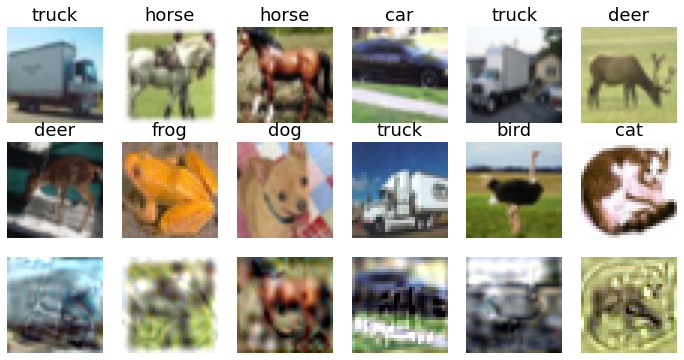

preparing mixed image for alpha 0.45...


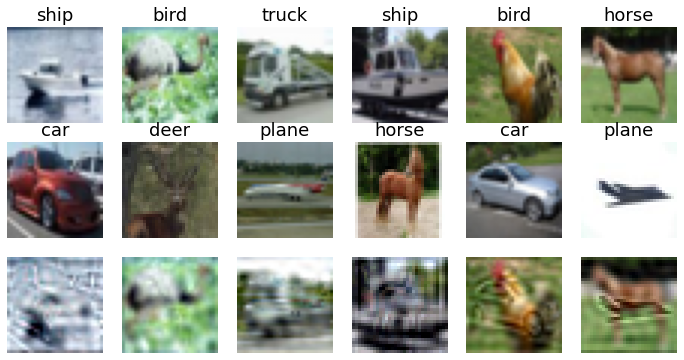

preparing mixed image for alpha 0.5...


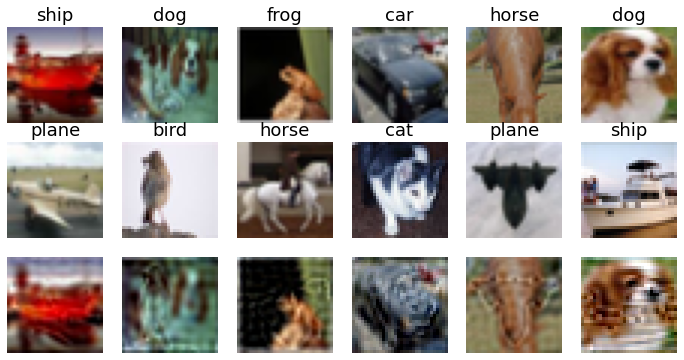

preparing mixed image for alpha 0.55...


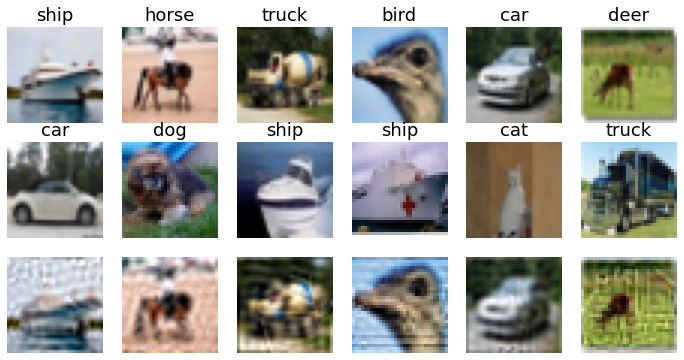

preparing mixed image for alpha 0.6...


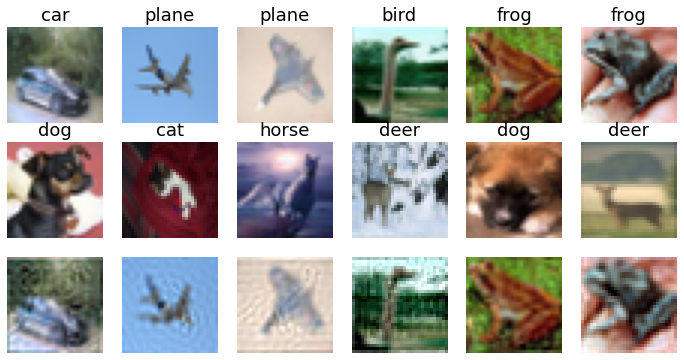

preparing mixed image for alpha 0.65...


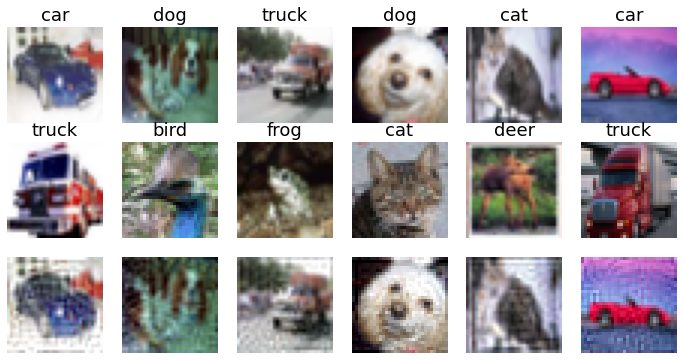

preparing mixed image for alpha 0.7...


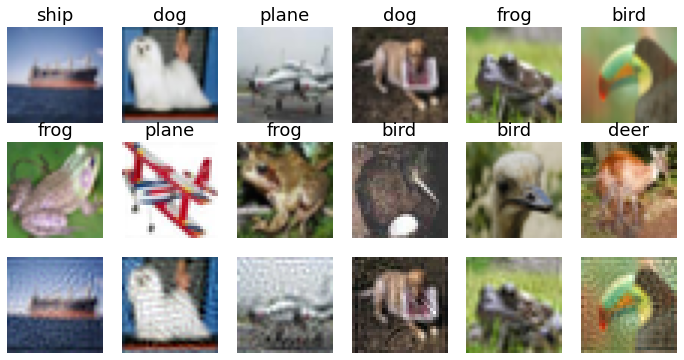

preparing mixed image for alpha 0.75...


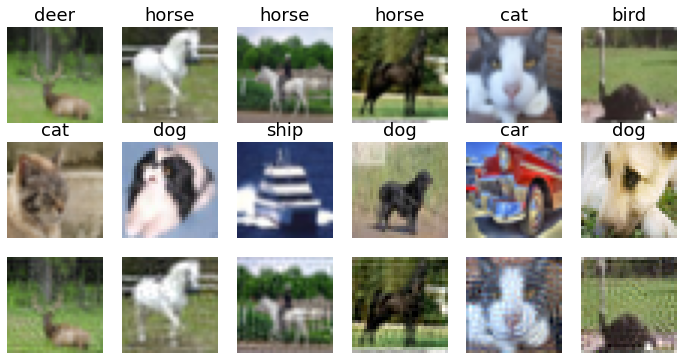

In [3]:
from scipy.fft import fft2, ifft2

class_names = (
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

for alpha in np.arange(1, 16)*0.05:
    print('preparing mixed image for alpha {:g}...'.format(alpha))
    resol = 32
    dx, dy = np.meshgrid(np.arange(resol)/resol, np.arange(resol)/resol)
    dx = np.mod(dx+0.5, 1)-0.5
    dy = np.mod(dy+0.5, 1)-0.5
    mask = ((dx**2+dy**2)**0.5<=alpha*0.5).astype(np.float)

    labels_high = labels_low.clone()
    last = 10000
    while True:
        idxs, = np.nonzero(labels_high.numpy()==labels_low.numpy())
        if idxs.size>0:
            if idxs.size<last:
                labels_high[idxs[np.random.permutation(idxs.size)]] = labels_high[idxs]
                last = idxs.size
            else:
                labels_high = labels_low.clone()[np.random.permutation(10000)]
                last = 10000
        else:
            break

    idxs = np.arange(10000)
    for c in range(10):
        _idxs, = np.nonzero(labels_low.numpy()==c)
        idxs[labels_high.numpy()==c] = np.random.permutation(_idxs)
    images_high = images_low[idxs]

    f_low = fft2(images_low.numpy())
    f_high = fft2(images_high.numpy())

    f_mix = f_low*mask+f_high*(1-mask)
    images_mix = np.real(ifft2(f_mix))
    
    images_mix = np.clip(images_mix, 0, 1)

    _, axes = plt.subplots(3, 6, figsize=(12, 6))
    for i, idx in enumerate(random.sample(range(10000), 6)):
        axes[0, i].imshow(images_low[idx].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title(class_names[labels_low[idx]])
        axes[1, i].imshow(images_high[idx].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title(class_names[labels_high[idx]])
        axes[2, i].imshow(images_mix[idx].transpose(1, 2, 0))
        axes[2, i].axis('off')
    plt.show()
    
    with open('vision_datasets/CIFAR10-EM/alpha_{:02d}.pickle'.format(int(100*alpha)), 'wb') as f:
        pickle.dump({
            'images_mix': images_mix,
            'idxs_low': np.arange(10000),
            'idxs_high': idxs,
            'labels_low': labels_low.numpy(),
            'labels_high': labels_high.numpy(),
        }, f)